# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.106541,False,2.077520
1,0.890946,False,1.391211
2,-1.286291,False,-1.313335
3,-0.184241,False,-0.593485
4,0.394889,False,-0.142599
...,...,...,...
995,0.042842,False,0.271499
996,-3.343183,True,2.246211
997,-1.990344,False,-2.025564
998,0.902961,True,5.604404


<AxesSubplot:xlabel='v0'>

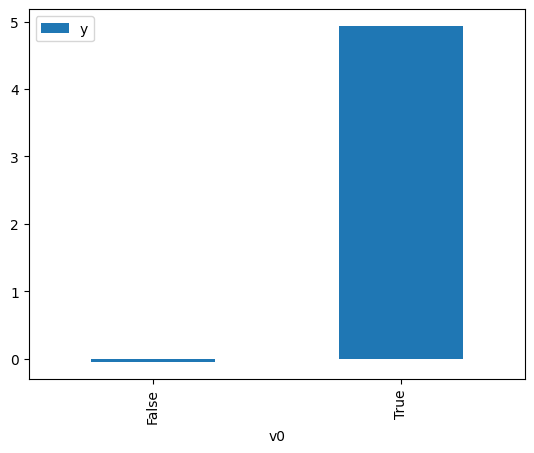

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

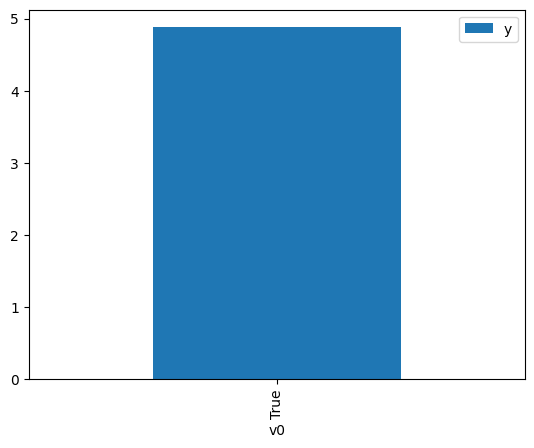

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.894939,False,-0.957796,0.626580,1.595965
1,1.141137,False,0.106765,0.355790,2.810648
2,-0.937575,False,-0.501500,0.632009,1.582257
3,-1.612638,False,-1.728523,0.712853,1.402813
4,-0.502169,False,0.622750,0.575226,1.738447
...,...,...,...,...,...
995,-0.497913,False,0.814285,0.574658,1.740164
996,-0.194490,False,-0.429796,0.533768,1.873472
997,-1.449108,False,0.396493,0.694243,1.440418
998,-1.524722,False,-0.564488,0.702932,1.422613


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.017836,True,4.851023,0.490285,2.039630
1,1.708278,True,6.026805,0.711611,1.405262
2,0.407381,True,6.382266,0.548153,1.824307
3,0.235990,True,5.496916,0.524897,1.905136
4,-2.106766,True,4.069689,0.235237,4.251024
...,...,...,...,...,...
995,-0.941768,True,5.748382,0.367459,2.721390
996,-0.034898,True,3.723432,0.487958,2.049356
997,0.097037,True,4.458147,0.505958,1.976450
998,-2.434455,True,3.941250,0.204595,4.887700


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                              6437.
Date:                Tue, 23 Aug 2022   Prob (F-statistic):                        0.00
Time:                        13:11:20   Log-Likelihood:                         -1405.7
No. Observations:                1000   AIC:                                      2815.
Df Residuals:                     998   BIC:                                      2825.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4727      0.032     14.977      0.000       0.411       0.535
x2             4.9688      0.045    109.638      0.000       4.880       5.058
==============================================================================
Omnibus:                        1.512   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.470   Jarque-Bera (JB):                1.437
Skew:                           0.020   Prob(JB):                        0.487
Kurtosis:                       3.181   Cond. No.                         1.47
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""